# Rozkład według wartości osobliwych

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color
import scipy

**Zadanie 1.**

Zastosowanie SVD do przeprowadzenia aproksymacji typu TLS.
W tym zadaniu wykorzystamy dane ze zbioru auto-mpg. Kod rozwiązujący problem TLS znajdziesz poniżej. Twoim zadaniem jest:
* Zapoznanie się ze sposobem działania kodu przeprowadzającego aproksymację TLS
* Porównanie wyników otrzymanych z metody TLS i OLS (np. poprzez narysowanie dwóch krzywych na jednym wykresie)

**Uwaga**: Poniżej nie znajdziesz kodu przeprowadzającego aproksymację OLS. Musisz napisać go samodzielnie. 

Dane do wykorzystania w tym ćwiczeniu znajdują się w pliku `auto_data2023.dat`. Jest to zmodyfikowana wersja zbioru auto-mpg dostępnego w repozytorium UCI.
Dane są zapisane w kolumnach:
* kolumna 0 - zużycie paliwa w milach/galon - `y1`
* kolumna 1 - pojemnosć skokową silnika     - `x` (zmienna niezależna)
* kolumna 2 - moc silnika                   - `y2`
* kolumna 3 - masa samochodu                - `y3`

Ponieważ dane pochodzą z USA, wszystkie pomiary są wyrażone w **miarach imperialnych** (cale, mile, galony).


In [3]:
import numpy as np

def tls(X, Y):
    # TLS - classical Total Least Square algorithm:
    m, n = X.shape  # n is the width of X (X is m by n)
    Z = np.concatenate((X, Y), axis=1)  # Z is X augmented with Y.
    U, S, V = np.linalg.svd(Z)  # find the SVD of Z.
    VXY = V[:n, n:]  # Take the block of V consisting of the first n rows and the n+1 to last column
    VYY = V[n:, n:]  # Take the bottom-right block of V.
    B = -VXY @ np.linalg.inv(VYY)
    return B



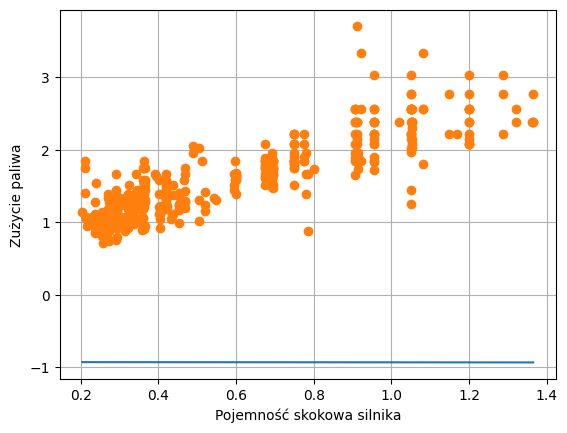

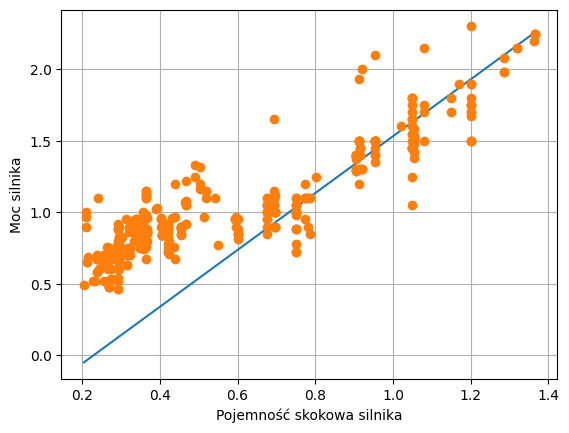

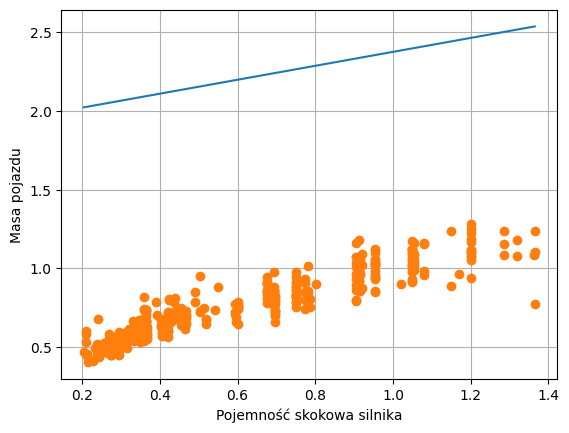

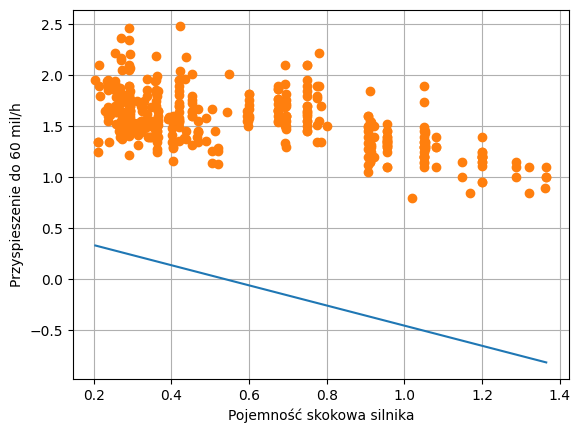

[[-0.92572014 -0.45606543  1.9327169   0.53300366]
 [-0.00333276  1.98794889  0.44250858 -0.98773772]]


In [4]:


A = np.loadtxt('auto_data2023.dat')
Skala = np.diag([30, 3, 10, 0.25, 100]) / 1000
A = A@ Skala


# Wersja z odwrotnością spalanie, tj. wyrażoną w galonach/milę
# Odwrotność spalania
A[:, 0] = A[:, 0]**(-1)

# Uporządkowanie kolumn macierzy danych: [x, y1, y2, y3, y4]
# Swap kolumn 1 i 2: % poj.silnika w 1. kolumnie, za nią zmienneobjaśniane

A[:, [1, 0]] = A[:, [0, 1]]
ind_x = 0  # kolumna z zmienną objaśniającą
ind_y = [1, 2, 3, 4]  # kolumny z zmiennymi objaśnianymi
rows, cols = A.shape
X = np.column_stack((np.ones(rows), A[:, ind_x]))  # afiniczna funkcja aproksymująca
Y = A[:, ind_y]  # zmienne objaśniane
a = tls(X, Y)  # rozwiązanie zadania TLS

# Wykresy danych i prostych aproksymujących (wykresy od numeru fig+1):
xmin = np.min(A[:, ind_x]) 
xmax = np.max(A[:, ind_x])
xx = np.linspace(xmin, xmax, 100)

titles = ['Zużycie paliwa', 'Moc silnika', 'Masa pojazdu', 'Przyspieszenie do 60 mil/h']
for i in range(4):
    a0 = a[0, i]
    a1 = a[1, i]
    yy = a0 + a1 * xx
    plt.figure()
    plt.plot(xx, yy, A[:, ind_x], A[:, ind_y[i]], 'o')
    plt.xlabel('Pojemność skokowa silnika')
    plt.ylabel(titles[i])
    plt.grid()
    plt.savefig(f's_{i}.png')

plt.show()
print(a)


**Zadanie 2.**

Wykorzystanie rozkładu SVD do kompresji czarno-białych obrazków.

Obrazek w skali szarości to tablica pikseli. Jeżeli jasność/kolor pikseli wyrazimy w skali szarości, to taki obrazek możemy potraktować jako zwykłą macierz. A zatem możliwe jest przeprowadzenie rozkładu SVD takiego rysunku/zdjęcia. Rozkład taki można wykorzystać do skompresowania informacji zawartych w macierzy. W tym celu, po przeprowadzeniu rozkładu, wybieramy $n$ **największych wartości osobliwych oraz związane z nimi lewo- i prawostronne wektory osobliwe** i przybliżamy oryginalną macierz [iloczynem diadycznym](https://pl.wikipedia.org/wiki/Iloczyn_diadyczny) tych wartości (czyli macierzami rzędu 1.).

Przygotowanie danych (szczegóły na zajęciach z uczenia maszynowego)

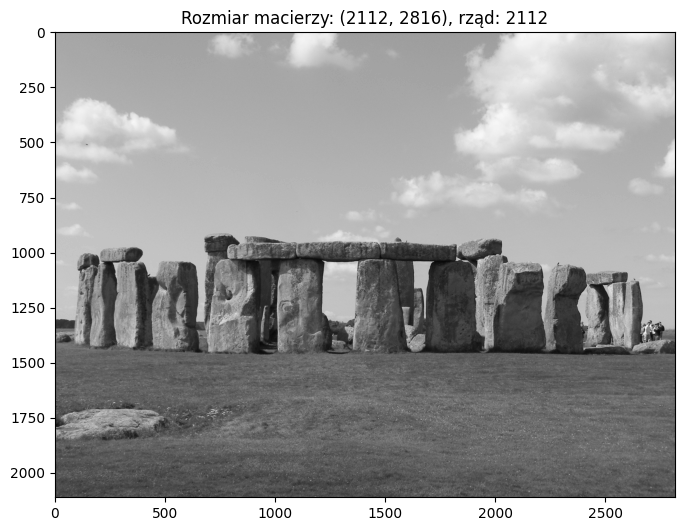

In [5]:
url = 'https://upload.wikimedia.org/wikipedia/commons/3/3c/Stonehenge2007_07_30.jpg'


imag = io.imread(url)
imag = color.rgb2gray(imag)

plt.figure(figsize=(8,8))
plt.imshow(imag,cmap='gray')
plt.title(f'Rozmiar macierzy: {imag.shape}, rząd: {np.linalg.matrix_rank(imag)}')
plt.show()

**Rozkład SVD**

In [6]:
U,s,Vt = np.linalg.svd(imag)

Informacja zapisana w pierwszej wartości szczególnej oraz związanych z nią wektorami lewo- i prawostronnym daje macierz o rzędzie 1. Wymiary tej macierzy odpowiadają wymiarom obrazka (wynika to z użycia iloczynu diadycznego).

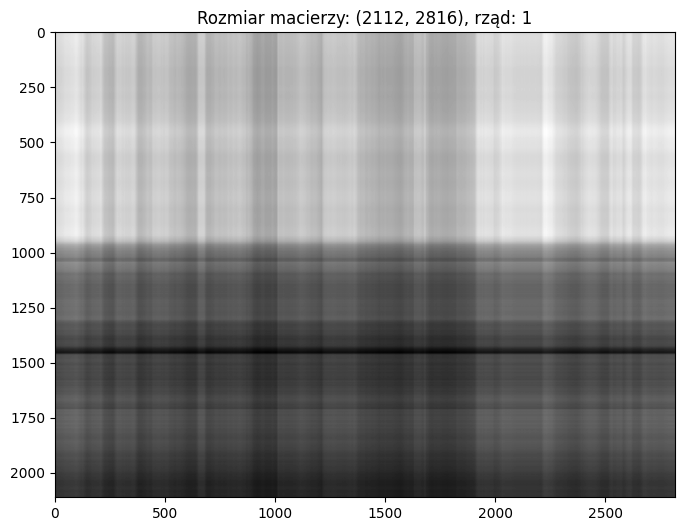

In [7]:
first = np.outer(U[:,0],Vt[0,:])*s[0]
plt.figure(figsize=(8,8))
plt.title(f'Rozmiar macierzy: {first.shape}, rząd: {np.linalg.matrix_rank(first)}')
plt.imshow(first,cmap='gray')

**Zadanie**

Wyświetl kilka pierwszych macierzy otrzymanych z iloczynów diadycznych kolejnych wartości osobliwych i związanych z nimi wektorów

**Właściwa kompresja**

Aby przybliżyć oryginalny obrazek, musimy **dodać do siebie** kolejne macierze rzędu pierwszego 1. Poniżej suma pierwszych 5 takich macierzy.

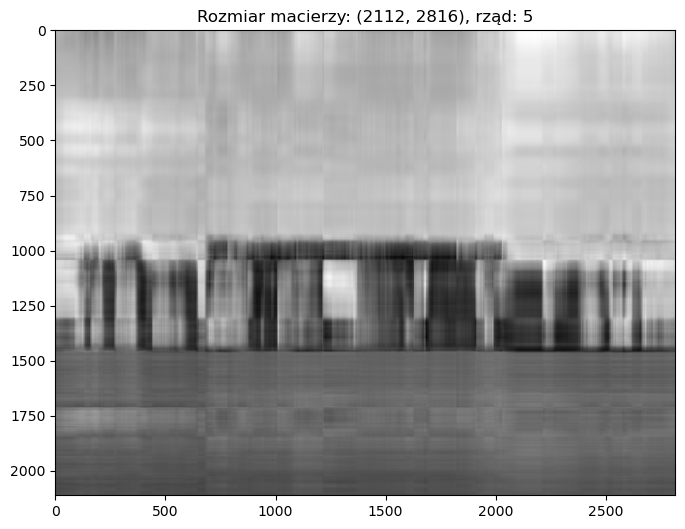

In [13]:
res = np.zeros(imag.shape)
for i in range(0,5):
    res += np.outer(U[:,i],Vt[i,:])*s[i]

plt.figure(figsize=(8,8))
plt.title(f'Rozmiar macierzy: {res.shape}, rząd: {np.linalg.matrix_rank(res)}')
plt.imshow(res,cmap='gray')


**Zadanie**

Sprawdz rezultaty dla sumy mniejszej/większej liczby macierzy rzędu 1. Znajdź liczbę macierzy, dla której rozróżnienie przybliżenia od oryginału nie będzie możliwe (dla człowieka). Oblicz ile pamięci potrzeba do zapisania informacji niezbędnych do odtworzenia takiego przybliżenia (*pamiętaj, że zapamiętujemy wartości i wektory szczególne, a nie same macierze rzędu 1.*). Porównaj otrzymany wynik z rozmiarem org. obrazka. Jaki stopień kompresji udało Ci się osiągnąć?

**Zadanie**

Powtórz eksperyment dla innego zdjęcia/rysunku. Powyższy kod zadziała dla dowolnego obrazka w formacie jpg. Aby zmienić rysunek należy zmienić adres w zmiennej `url`. Spróbuj znaleźć obrazki, dla których wymagane jest zapamiętanie mniejszej ilości informacji (*wskazówka: poszukaj obrazków zawierających powtarzające się wzory*).

**Zadanie**

Zastanów się nad bardziej poprawnymi (nie na oko) sposobami oceny jakości tej metody kompresji